# Predict Maturity

Script to predict a50 and s parameters for carcharhinid species using outputs of maturity model

currently based on maturity model 34

The primary model to describe the shape of maturity ogives uses z-transformed covariates in order to see the effects of each covariate relative to the others (using all z-scores makes effect sizes comparable).  However, to predict new a50 and s values using this model, we need model outputs that allow for the new values to be expressed on teh same scale as the raw data (ie a50 values should be 0-20 and S values 0-10).  Therefore have to run the a secondary model using mean-centred covariates that can be transformed back into the raw data scale.  Can't interpret the results from this model as easily as for the primary model, but more useful for prediction.  



In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pymc3 as pm
import theano as T
import theano.tensor as tt
import seaborn as sns
import scipy as sp
import pdb
import os as os

# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Function to mean-centre covariates
def centre(x):
    return (x-np.mean(x))

def spanzero(pair):
    out = True
    if all(pair<0) or all(pair>0):
        out = False
    return out

In [97]:
# upload results from model 34 
# upload csv file
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
mat1 = pd.read_csv('mat34_model_results.csv')
mat1.head()

,Unnamed: 0,a50___0,a50___1,a50___2,a50___3,a50___4,a50___5,a50___6,a50___7,a50___8,...,mu_S__15,mu_S__16,mu_S__17,mu_S__18,mu_S__19,mu_S__20,mu_S__21,mu_S__22,mu_S__23,S2
0,0,5.071116,8.654512,8.035846,7.074909,6.479836,6.421795,5.931839,7.296132,4.466762,...,1.541260,2.190006,2.248719,0.488519,0.674568,2.593593,4.405870,3.374279,1.199453,0.008549
1,1,5.678893,9.215286,7.161630,6.206210,6.359337,6.137848,5.638936,8.431008,4.282187,...,1.495380,2.218694,2.243547,0.483128,0.659707,2.730171,5.268905,3.089758,1.197629,0.008285
2,2,7.426133,8.898957,8.108833,7.145516,4.765418,4.857604,4.324990,8.126404,4.900914,...,1.550105,2.161561,2.112974,0.489500,0.653117,2.602317,5.227455,3.069988,1.261591,0.008326
3,3,8.002271,8.697707,8.068058,7.132552,4.883529,5.007759,4.503022,8.034748,4.919798,...,1.573953,2.068938,2.162689,0.488390,0.634102,2.741109,5.519238,2.904012,1.208095,0.008201
4,4,8.243710,8.130488,9.088772,8.100271,4.841366,5.332223,4.814839,8.235093,4.694449,...,1.545720,2.188825,2.161886,0.482772,0.643297,2.675570,5.848157,2.977458,1.202264,0.008114


In [91]:
# upload results from secondary model if needed
# upload csv file
#os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
#mat2 = pd.read_csv('mat29_model_results.csv')

In [98]:
mat1.columns.values

array(['Unnamed: 0', 'a50___0', 'a50___1', 'a50___2', 'a50___3',
       'a50___4', 'a50___5', 'a50___6', 'a50___7', 'a50___8', 'a50___9',
       'a50___10', 'a50___11', 'a50___12', 'a50___13', 'a50___14',
       'a50___15', 'a50___16', 'a50___17', 'a50___18', 'a50___19',
       'a50___20', 'a50___21', 'a50___22', 'a50___23', 'Lmax', 'Depth',
       'K', 'Interbirth_interval', 'Amax', 'Litter', 'Offspring_size',
       'Trophic', 'Temperature', 'S___0', 'S___1', 'S___2', 'S___3',
       'S___4', 'S___5', 'S___6', 'S___7', 'S___8', 'S___9', 'S___10',
       'S___11', 'S___12', 'S___13', 'S___14', 'S___15', 'S___16',
       'S___17', 'S___18', 'S___19', 'S___20', 'S___21', 'S___22',
       'S___23', 'Lmax-S', 'Depth-S', 'K-S', 'Amax-S', 'Trophic-S',
       'Temperature-S', 'Ga50', 'a50_sigma', 'GS', 'S_sigma', 'mu_a50__0',
       'mu_a50__1', 'mu_a50__2', 'mu_a50__3', 'mu_a50__4', 'mu_a50__5',
       'mu_a50__6', 'mu_a50__7', 'mu_a50__8', 'mu_a50__9', 'mu_a50__10',
       'mu_a50__11', 'm

In [99]:
#choose just columns we want so easier to read

mat1 = mat1.filter(['Ga50', 'Lmax', 'Depth', 'K',
       'Interbirth_interval', 'Amax', 'Litter', 'Offspring_size',
       'Trophic', 'Temperature', 'GS', 'Lmax-S', 'K-S', 'Amax-S', 'Depth-S', 'Temperature-S',
       'Trophic-S'], axis=1)


In [6]:
#mat2.columns.values

In [94]:
#choose just columns we want so easier to read

# mat2 = mat2.filter(['Ga50', 'Lmax', 'Depth',
#       'Interbirth_interval', 'Amax', 'Litter', 'Offspring_size',
#       'Trophic', 'GS', 'K-S', 'Amax-S', 'Depth-S'
#       'Trophic-S'], axis=1)

### Model Input Traits Data  

Upload data that was used for maturity model so can calculate mean values for each covariate and use those to transform new data.  New trait data has to be expressed on the same scale as that of the model, so that the effect sizes make sense.  

In [154]:
#upload data
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\in')
adata = pd.read_excel('full_dataset.xlsx')
#get rid of species that don't have full complement of trait data
adata = adata[adata.param_complete==0]
# take out sharpnoses that were not in predict model
out = ['GSH-I-17', 'SPD-I-19', 'MLK-I-17']
bdata = adata[~adata.Stock_Year.isin(out)]
# only species with age-structured data
mdata= bdata[bdata.SA_mat=='A']

# make an index for stock assessment
StockYr, Is = indexall(mdata.Stock_Year.values)
nstocks = len(StockYr)


In [155]:
#Index of covariates
Sind = np.array([list(mdata.Stock_Year.values).index(S) for S in StockYr])

#make arrays of all the covariates
#put Sind after all of these so they match the length of StockYr
rLMAX = mdata.lmax_cm.values[Sind]
rHAB = mdata.habitat.values[Sind]
rTROPH = mdata.trophic_level.values[Sind]
rOFFSZ = mdata.offspring_size_mm.values[Sind]
#rROFFSZ = mdata.relative_offspring_size.values[Sind]
rLITT = mdata.litter_size.values[Sind]
#RLITT = mdata.relative_litter_size.values[Sind]
rINTR = mdata.interbirth_interval_yrs.values[Sind]
rAMAT = mdata.age_50_maturity.values[Sind]
rLMAT = mdata.length_maturity_cm.values[Sind]
rLINF = mdata.linf_cm.values[Sind]
rK = mdata.growth_coeff_k.values[Sind]
rAMAX = mdata.age_max_yrs.values[Sind]
rDEP = mdata.depth_ave.values[Sind]
rDEPMAX = mdata.depth_max.values[Sind]
rTEMP = mdata.temp_pref.values[Sind]

In [156]:
# get mean values for each covariate
# remember to use correct scale because some were transfromed before centred in model
mLMAX = np.mean(np.log(rLMAX))
mTROPH = np.mean(rTROPH)
mAMAX = np.mean(np.log(rAMAX))
mOFFSZ = np.mean(rOFFSZ/100)
mLITT = np.mean(np.log(rLITT))
mDEP = np.mean(np.log(rDEP))
mK = np.mean(rK)
mINTR = np.mean(rINTR)
mTEMP = np.mean(np.log(rTEMP))
mLMAT = np.mean(np.log(rLMAT))

In [11]:
#check you have the right mean values against data in model 34
mTROPH

4.309166666666667

In [157]:
mK

0.191107161

### New Species Traits Data  

Now transform the trait data for the new species (species we want to predict what their ogives are) in the same way the covariate data was transformed in the model. This way the effect sizes spit out by the model will match the scale of values in the new dataset.

In [158]:
# upload trait values for new species - first average values (sheet 3)
# also  upload sheet with predict traits by stock
xl = pd.ExcelFile('predict_car_traits.xlsx')
tave = pd.read_excel(xl, 'Sheet3')
tstock = pd.read_excel(xl, 'Sheet1')

tave.head()

,species_full,species_common,depth,litter_size,offspring_size,lmat,amax,lmax,k,linf,interbirth_interval,amat,trophic,temp,in_predict_model
0,Carcharhinus acronotus,Blacknose shark,36.5,5.000000,500.0,115.000000,19.75,130.000000,0.199479,179.779140,2.0,3.25,4.36,21.5,1
1,Carcharhinus albimarginatus,Silvertip shark,400.5,6.000000,737.5,205.350000,32.00,272.833333,0.020000,498.000000,1.0,14.80,4.21,27.1,0
2,Carcharhinus altimus,Bignose shark,417.5,6.666667,625.0,234.500000,21.00,266.500000,0.180500,270.714996,2.0,NaN,4.81,19.9,0
3,Carcharhinus amblyrhynchoides,Graceful shark,25.0,2.666667,475.0,128.333333,NaN,182.680000,NaN,NaN,1.0,NaN,4.22,28.0,0
4,Carcharhinus amblyrhynchos,Grey reef shark,140.0,9.000000,485.0,137.672500,15.00,190.000000,0.134000,196.100000,2.0,8.50,4.11,25.0,0


## Species Predictions  

Combine model results with new species trait data to predict new stock-specific a50 and s

In [80]:
# clean up data - first with the average dataset
# don't need amat
tave1 = tave.drop('amat', axis='columns')
# take out species with missing traits data
tave2 = tave1.dropna()
# take outspecies which wherein the original mat ogives dataset
tave3 = tave2[tave2.in_predict_model==0]

In [81]:
tave3.columns, tave3.shape

(Index(['species_full', 'species_common', 'depth', 'litter_size',
        'offspring_size', 'lmat', 'amax', 'lmax', 'k', 'linf',
        'interbirth_interval', 'trophic', 'temp', 'in_predict_model'],
       dtype='object'),
 (25, 14))

In [159]:
del tdata

In [160]:
#set up new dataframe to hold transformed data
columns= ['species_full', 'species_common', 'Depth', 'Litter',
        'Offspring_size', 'Amax', 'Lmax', 'K',
        'Interbirth_interval', 'Trophic', 'Temperature']
index = [1,  2,  4,  5, 13, 14, 15, 20, 23, 24, 26, 28, 30, 33, 38, 41, 43,
             44, 46, 47, 48, 49, 50, 52, 53]
tdata = pd.DataFrame(index=index, columns=columns)

In [161]:
# make a new dataframe with transformed values
tdata.species_full=tave3.species_full
tdata.species_common=tave3.species_common
tdata.Trophic = tave3.trophic-mTROPH
tdata.Offspring_size = (tave3.offspring_size/100)-mOFFSZ 
tdata.Litter = np.log(tave3.litter_size)- mLITT
tdata.Amax = np.log(tave3.amax) - mAMAX
tdata.K = tave3.k - mK
tdata.Depth = np.log(tave3.depth) - mDEP
tdata.Interbirth_interval = tave3.interbirth_interval - mINTR
tdata.Lmax = np.log(tave3.lmax)- mLMAX
tdata.Temperature = np.log(tave3.temp) - mTEMP
tdata.head()

,species_full,species_common,Depth,Litter,Offspring_size,Amax,Lmax,K,Interbirth_interval,Trophic,Temperature
1,Carcharhinus albimarginatus,Silvertip shark,1.664332,-0.046072,1.846667,0.597698,0.476781,-0.171107,-0.791667,-0.099167,0.139691
2,Carcharhinus altimus,Bignose shark,1.705903,0.059289,0.721667,0.176484,0.453295,-0.010607,0.208333,0.500833,-0.169123
4,Carcharhinus amblyrhynchos,Grey reef shark,0.613261,0.359393,-0.678333,-0.159988,0.114944,-0.057107,0.208333,-0.199167,0.059033
5,Carcharhinus amboinensis,Pigeye shark,-0.010894,0.199051,0.771667,0.533159,0.433717,-0.046107,0.208333,-0.029167,0.161590
13,Carcharhinus falciformis,Silky shark,1.193079,0.122263,1.511667,0.377155,0.526531,-0.086311,0.208333,0.200833,-0.115320


In [162]:
nrows = tdata.shape[0]
nrows

25

In [163]:
# Create empty containers to hold results from combining model with new data
# note that np.empty doesn't fill the array with 0s, it just puts random values in that you then have to replace

#info on a50
a50mu = np.empty(nrows)
a5095 = np.empty(nrows)
a5025 = np.empty(nrows)
a5075 = np.empty(nrows)
a505 = np.empty(nrows)

# info on s
smu = np.empty(nrows)
s95 = np.empty(nrows)
s25 = np.empty(nrows)
s75 = np.empty(nrows)
s5 = np.empty(nrows)

AGE = list(range(0,50))

# empty matrices for age structured data
matmu = np.zeros((nrows, len(AGE)))
mat95 = np.zeros((nrows, len(AGE)))
mat75 = np.zeros((nrows, len(AGE)))
mat25 = np.zeros((nrows, len(AGE)))
mat5 = np.zeros((nrows, len(AGE)))

In [164]:
tdata.columns

Index(['species_full', 'species_common', 'Depth', 'Litter', 'Offspring_size',
       'Amax', 'Lmax', 'K', 'Interbirth_interval', 'Trophic', 'Temperature'],
      dtype='object')

In [165]:
mat1.columns

Index(['Ga50', 'Lmax', 'Depth', 'K', 'Interbirth_interval', 'Amax', 'Litter',
       'Offspring_size', 'Trophic', 'Temperature', 'GS', 'Lmax-S', 'K-S',
       'Amax-S', 'Depth-S', 'Temperature-S', 'Trophic-S'],
      dtype='object')

In [166]:
# fill in empty arrays with predict data
for i in range(nrows):

    # make temporary object with data from just one species at a time
    tmp = tdata.iloc[i]
    # create vectors of a50 and S values for each species
    # make sure you match the right covariates to a50 and S depending on teh model match
    Exa50 = mat1['Ga50'].values + mat1['Depth'].values*tmp['Depth'] + mat1['K'].values*tmp['K'] + mat1['Amax'].values*tmp['Amax'] + mat1['Trophic'].values*tmp['Trophic'] + mat1['Lmax'].values*tmp['Lmax'] + mat1['Depth'].values*tmp['Depth'] + mat1['Interbirth_interval'].values*tmp['Interbirth_interval'] + mat1['Litter'].values*tmp['Litter'] + mat1['Offspring_size'].values*tmp['Offspring_size'] + mat1['Temperature'].values*tmp['Temperature']
    ExS = mat1['GS'] + mat1['K-S'].values*tmp['K'] + mat1['Depth-S'].values*tmp['Depth'] + mat1['Trophic-S'].values*tmp['Trophic'] + mat1['Amax-S'].values*tmp['Amax'] + mat1['Lmax-S'].values*tmp['Lmax'] + mat1['Temperature-S'].values*tmp['Temperature']
    
    # create age structured data
    mu = np.array([1/(1+np.exp(-s*(AGE-a))) for s,a in zip(ExS, Exa50)])
        
        
    # a50 values to empty a50 objects
    a50mu[i] = np.median(Exa50)
    a5095[i] = np.percentile(Exa50, 95)
    a5075[i] = np.percentile(Exa50, 75)
    a5025[i] = np.percentile(Exa50, 25)
    a505[i] = np.percentile(Exa50, 5)
    
      # add S values to empty S objects
    smu[i] = np.median(ExS)
    s5[i] = np.percentile(ExS, 5)
    s25[i] = np.percentile(ExS, 25)
    s75[i] = np.percentile(ExS, 75)
    s95[i] = np.percentile(ExS, 95)
    
    # add age-structured maturity data to empty objects
    # note choosing to calculate along 0 axis is like calculate a total row at the bottom of a spreadsheet
    matmu[i] = np.median(mu, axis=0)
    mat95[i] = np.percentile(mu,95, axis=0)
    mat75[i] = np.percentile(mu, 75, axis=0)
    mat25[i] = np.percentile(mu, 25, axis=0)
    mat5[i] = np.percentile(mu, 5, axis=0)

In [167]:
#check results
s95

array([1.91552184, 2.12323344, 2.91733981, 2.08126601, 1.55749596,
       3.25428722, 2.29819799, 1.40888089, 3.9938114 , 3.25784176,
       1.67882627, 3.10764722, 1.92132337, 1.87382615, 1.97741077,
       4.54403407, 1.93173691, 1.4729225 , 5.26143624, 6.29197781,
       4.7670825 , 5.58987065, 4.61709619, 4.64605549, 6.4952395 ])

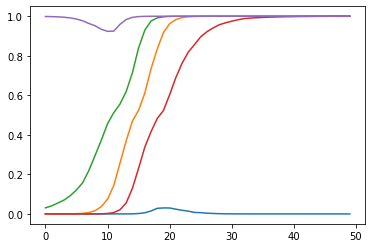

In [168]:
# Check for loop results
# species 1 is bignose
plt.plot(AGE, mat5[1])
plt.plot(AGE, matmu[1])
plt.plot(AGE, mat75[1])
plt.plot(AGE, mat25[1])
plt.plot(AGE, mat95[1])

In [169]:
tdata.iloc[1]

species_full           Carcharhinus altimus
species_common                Bignose shark
Depth                                1.7059
Litter                            0.0592886
Offspring_size                     0.721667
Amax                               0.176484
Lmax                               0.453295
K                                -0.0106072
Interbirth_interval                0.208333
Trophic                            0.500833
Temperature                       -0.169123
Name: 2, dtype: object

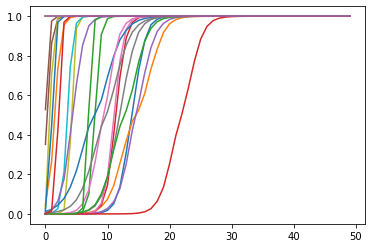

In [170]:
# Plot all new ogives

for i in range(nrows):
    plt.plot(AGE, matmu[i])
    

### Save results as dataframe

In [172]:
result1 = pd.DataFrame()

for i in range(nrows):
    tmp = tdata.iloc[i]
    out = pd.DataFrame()
    out['matmu']=pd.Series(matmu[i])
    out['mat5']=pd.Series(mat5[i])
    out['mat25']=pd.Series(mat25[i])
    out['mat75']=pd.Series(mat75[i])
    out['mat95']=pd.Series(mat95[i])
    out['species_full']=tmp.species_full
    result1 = result1.append(out)
 
result1['age'] = result1.index

In [173]:
result1

,matmu,mat5,mat25,mat75,mat95,species_full,age
0,1.595300e-07,4.066709e-13,1.021700e-09,0.000016,0.007475,Carcharhinus albimarginatus,0
1,5.377997e-07,2.348999e-12,4.302385e-09,0.000039,0.011023,Carcharhinus albimarginatus,1
2,1.679828e-06,1.419363e-11,1.812438e-08,0.000090,0.016558,Carcharhinus albimarginatus,2
3,5.588707e-06,8.089609e-11,6.921235e-08,0.000221,0.029293,Carcharhinus albimarginatus,3
4,1.751906e-05,4.142797e-10,2.834092e-07,0.000536,0.048027,Carcharhinus albimarginatus,4
...,...,...,...,...,...,...,...
45,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,Scoliodon laticaudus,45
46,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,Scoliodon laticaudus,46
47,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,Scoliodon laticaudus,47
48,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,Scoliodon laticaudus,48


In [174]:
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
result1.to_csv('mat34_predicted_ogives_species.csv')
# remember first column is age

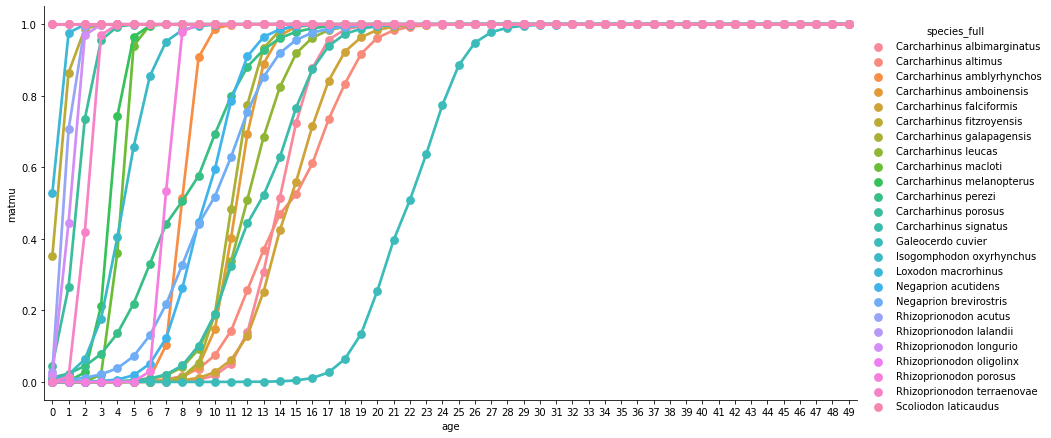

In [175]:
sns.catplot(x='age', y='matmu', hue='species_full', height=6, aspect=2, kind='point', data=result1);

#os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
#plt.savefig('predicted-ogives.jpg')

## Do species summary stats  

need these to feed in to R for paper figures  
 make a table of a50 per species

In [176]:
a5095

array([18.27763078, 20.02668457, 11.27132007, 13.44980001, 18.25002164,
        4.52393734, 13.97136568, 13.84470901,  7.4469897 ,  6.24253777,
       11.32812275,  7.26369068, 17.23262132, 26.65701175,  8.8882797 ,
        2.76821901, 12.35246518, 12.97330609,  3.37507825,  0.26365603,
        4.44116078, -1.82020182, 12.2505595 ,  4.84951173, -2.30924506])

In [187]:
a50result1 = pd.DataFrame()

for i in range(nrows):
    tmp = tdata.iloc[i]
    out = pd.DataFrame()
    out['a50mu']=pd.Series(a50mu[i])
    out['a505']=pd.Series(a505[i])
    out['a5025']=pd.Series(a5025[i])
    out['a5075']=pd.Series(a5075[i])
    out['a5095']=pd.Series(a5095[i])
    out['species_full']=tmp.species_full
    a50result1 = a50result1.append(out)
 
#result1['age'] = result1.index

In [188]:
a50result1

,a50mu,a505,a5025,a5075,a5095,species_full
0,13.882811,9.664050,12.178637,15.707560,18.277631,Carcharhinus albimarginatus
0,14.415836,9.302394,12.411587,16.731778,20.026685,Carcharhinus altimus
0,7.977298,5.081573,6.756113,9.269626,11.271320,Carcharhinus amblyrhynchos
0,11.326152,9.121970,10.450384,12.207882,13.449800,Carcharhinus amboinensis
0,14.520481,11.469222,13.253804,16.061450,18.250022,Carcharhinus falciformis
0,0.245125,-4.375613,-1.567835,1.967879,4.523937,Carcharhinus fitzroyensis
0,11.050723,8.541247,10.018554,12.189403,13.971366,Carcharhinus galapagensis
0,11.919750,10.007876,11.119731,12.694207,13.844709,Carcharhinus leucas
0,4.175094,0.878736,2.965828,5.524203,7.446990,Carcharhinus macloti
0,3.545847,0.902396,2.468243,4.642227,6.242538,Carcharhinus melanopterus


In [189]:
#export table
a50result1.to_csv('mat34_predicteda50s_species.csv')

 make a table of S per species

In [180]:
s75

array([1.46081135, 1.31616693, 2.52583586, 1.67312551, 1.15236465,
       2.81278311, 1.84145837, 1.05489373, 3.61705659, 2.77707051,
       0.99908201, 2.54273903, 1.25621159, 1.28673903, 1.54598912,
       4.04391877, 1.39395539, 0.96213751, 4.75907887, 5.74538582,
       4.22420816, 5.15055446, 4.07252324, 4.20146908, 5.82334071])

In [181]:
# make a table of S per species
Sresult1 = pd.DataFrame()

for i in range(nrows):
    tmp = tdata.iloc[i]
    out = pd.DataFrame()
    out['smu']=pd.Series(smu[i])
    out['s5']=pd.Series(s5[i])
    out['s25']=pd.Series(s25[i])
    out['s75']=pd.Series(s75[i])
    out['s95']=pd.Series(s95[i])
    out['species_full']=tmp.species_full
    Sresult1 = Sresult1.append(out)
 

In [190]:
Sresult1

,smu,s5,s25,s75,s95,species_full
0,1.157616,0.377166,0.859810,1.460811,1.915522,Carcharhinus albimarginatus
0,0.795207,-0.507442,0.253969,1.316167,2.123233,Carcharhinus altimus
0,2.287011,1.634177,2.037273,2.525836,2.917340,Carcharhinus amblyrhynchos
0,1.399284,0.716615,1.130697,1.673126,2.081266,Carcharhinus amboinensis
0,0.857199,0.128863,0.575567,1.152365,1.557496,Carcharhinus falciformis
0,2.507557,1.819225,2.218761,2.812783,3.254287,Carcharhinus fitzroyensis
0,1.524803,0.751174,1.210882,1.841458,2.298198,Carcharhinus galapagensis
0,0.849232,0.302385,0.629993,1.054894,1.408881,Carcharhinus leucas
0,3.372202,2.829154,3.159297,3.617057,3.993811,Carcharhinus macloti
0,2.418194,1.573130,2.056328,2.777071,3.257842,Carcharhinus melanopterus


In [191]:
#export table
Sresult1.to_csv('mat34_predictedSs_species.csv')

## Stock Predictions  

Combine model results with new species trait data to predict new species a50 and s

Now for mat 34

In [192]:
tstock.head()

,species_full,species_common,Stock,FAO_Area,Region,trophic,offspring_size,litter_size,interbirth_interval,amat,k,lmax,amax,temp,depth,in_predict_model
0,Carcharhinus acronotus,Blacknose shark,BNOS-21,21,Northwest Atlantic,4.36,500.0,5.0,2.0,4.5,0.183633,130.0,20.0,21.5,36.5,1
1,Carcharhinus acronotus,Blacknose shark,BNOS-31,31,Western Atlantic,4.36,500.0,5.0,2.0,2.8,0.288322,130.0,19.0,21.5,36.5,1
2,Carcharhinus albimarginatus,Silvertip shark,STIP-57,57,Eastern Indian,4.21,725.0,6.0,1.0,14.8,0.020000,272.0,32.0,27.1,400.5,0
3,Carcharhinus albimarginatus,Silvertip shark,STIP-71,71,Southwest Pacific,4.21,750.0,6.0,1.0,14.8,0.020000,275.0,32.0,27.1,400.5,0
4,Carcharhinus altimus,Bignose shark,BIG-31,31,Western Atlantic,4.81,420.0,9.0,2.0,NaN,0.210000,282.0,21.0,19.9,417.5,0


In [193]:
# clean up data - first with the average dataset
# don't need amat
tstock1 = tstock.drop('amat', axis='columns')
# take out species with missing traits data
tstock2 = tstock1.dropna()
# take outspecies which wherein the original mat ogives dataset
tstock3 = tstock2[tstock2.in_predict_model==0]

In [194]:
tstock3.columns, tstock3.index

(Index(['species_full', 'species_common', 'Stock', 'FAO_Area', 'Region',
        'trophic', 'offspring_size', 'litter_size', 'interbirth_interval', 'k',
        'lmax', 'amax', 'temp', 'depth', 'in_predict_model'],
       dtype='object'),
 Int64Index([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  14,  15,
              16,  17,  18,  21,  22,  24,  25,  26,  27,  28,  29,  30,  31,
              32,  33,  34,  36,  37,  38,  39,  40,  43,  44,  45,  46,  47,
              49,  50,  51,  52,  53,  55,  56,  57,  58,  59,  60,  62,  63,
              64,  65,  66,  67,  68,  69,  70,  73,  74,  75,  76,  77,  78,
              79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
              93,  94,  95,  96,  97,  98,  99, 100, 101, 104, 105, 106, 108],
            dtype='int64'))

In [195]:
# delete tsdata just in case there's an existing copy
del tsdata

#set up new dataframe to hold transformed data
columns= ['species_full', 'species_common', 'Stock', 'Region', 'Depth', 'Litter',
        'Offspring_size', 'Amax', 'Lmax', 'K',
        'Interbirth_interval', 'Trophic', 'Temperature']
index = [ 2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  14,  15,
              16,  17,  18,  21,  22,  24,  25,  26,  27,  28,  29,  30,  31,
              32,  33,  34,  36,  37,  38,  39,  40,  43,  44,  45,  46,  47,
              49,  50,  51,  52,  53,  55,  56,  57,  58,  59,  60,  62,  63,
              64,  65,  66,  67,  68,  69,  70,  73,  74,  75,  76,  77,  78,
              79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
              93,  94,  95,  96,  97,  98,  99, 100, 101, 104, 105, 106, 108]
tsdata = pd.DataFrame(index=index, columns=columns)

In [196]:
# fill in new dataframe with transformed values
tsdata.species_full=tstock3.species_full
tsdata.species_common = tstock3.species_common
tsdata.Stock = tstock3.Stock
tsdata.Region = tstock3.Region
tsdata.Trophic = tstock3.trophic-mTROPH
tsdata.Offspring_size = (tstock3.offspring_size/100)-mOFFSZ 
tsdata.Litter = np.log(tstock3.litter_size)- mLITT
tsdata.Amax = np.log(tstock3.amax) - mAMAX
tsdata.K = tstock3.k - mK
tsdata.Depth = np.log(tstock3.depth) - mDEP
tsdata.Interbirth_interval = tstock3.interbirth_interval - mINTR
tsdata.Lmax = np.log(tstock3.lmax)- mLMAX
tsdata.Temperature = np.log(tstock3.temp) - mTEMP
tsdata

,species_full,species_common,Stock,Region,Depth,Litter,Offspring_size,Amax,Lmax,K,Interbirth_interval,Trophic,Temperature
2,Carcharhinus albimarginatus,Silvertip shark,STIP-57,Eastern Indian,1.664332,-0.046072,1.721667,0.597698,0.473722,-0.171107,-0.791667,-0.099167,0.139691
3,Carcharhinus albimarginatus,Silvertip shark,STIP-71,Southwest Pacific,1.664332,-0.046072,1.971667,0.597698,0.484691,-0.171107,-0.791667,-0.099167,0.139691
4,Carcharhinus altimus,Bignose shark,BIG-31,Western Atlantic,1.705903,0.359393,-1.328333,0.176484,0.509827,0.018893,0.208333,0.500833,-0.169123
5,Carcharhinus altimus,Bignose shark,BIG-57,Eastern Indian,1.705903,-0.451537,2.771667,0.176484,0.393373,-0.040107,0.208333,0.500833,-0.169123
6,Carcharhinus altimus,Bignose shark,BIG-71,Southwest Pacific,1.705903,0.108079,-1.328333,0.176484,0.393373,-0.040107,0.208333,0.500833,-0.169123
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,Rhizoprionodon taylori,Australian sharpnose shark,AUSH-71,Southwest Pacific,0.682254,-0.333754,-3.028333,-1.076279,-0.775371,0.821893,-0.791667,0.190833,0.059033
104,Scoliodon laticaudus,Spadenose shark,SPD-51,Western Indian Ocean,-1.886035,0.108079,-4.028333,-0.788597,-0.883584,0.348893,-0.791667,-0.509167,0.135994
105,Triaenodon obesus,Whitetip reef shark,WHT-51,Western Indian Ocean,0.780590,-0.921541,-0.328333,0.350838,-0.030183,-0.141107,0.208333,-0.119167,0.157973
106,Triaenodon obesus,Whitetip reef shark,WHT-57,Eastern Indian,0.780590,-0.921541,0.071667,0.350838,-0.069485,-0.141107,0.208333,-0.119167,0.157973


In [197]:
nrows = tsdata.shape[0]
nrows

91

In [203]:
# Mat 34 stock level
# Create empty containers to hold results from combining model with new data
# note that np.empty doesn't fill the array with 0s, it just puts random values in that you then have to replace

#info on a50
a50mu = np.empty(nrows)
a5095 = np.empty(nrows)
a5025 = np.empty(nrows)
a5075 = np.empty(nrows)
a505 = np.empty(nrows)

# info on s
smu = np.empty(nrows)
s95 = np.empty(nrows)
s25 = np.empty(nrows)
s75 = np.empty(nrows)
s5 = np.empty(nrows)

AGE = list(range(0,50))

# empty matrices for age structured data
matmu = np.zeros((nrows, len(AGE)))
mat95 = np.zeros((nrows, len(AGE)))
mat75 = np.zeros((nrows, len(AGE)))
mat25 = np.zeros((nrows, len(AGE)))
mat5 = np.zeros((nrows, len(AGE)))

In [204]:
a505

array([6.24273090e-312, 6.24273097e-312, 6.24273090e-312, 6.24273097e-312,
       6.24273096e-312, 6.24273097e-312, 6.24273090e-312, 6.24273096e-312,
       6.24273090e-312, 6.24273092e-312, 6.24273400e-312, 6.24273090e-312,
       6.24273090e-312, 6.24273090e-312, 6.24273093e-312, 6.24273090e-312,
       6.24273090e-312, 6.24273097e-312, 6.24273090e-312, 6.24273090e-312,
       6.24273096e-312, 6.24273096e-312, 6.24273090e-312, 6.24273090e-312,
       6.24273156e-312, 6.24273096e-312, 6.24273090e-312, 6.24273092e-312,
       6.24273292e-312, 6.24291590e-312, 6.24291952e-312, 6.24291995e-312,
       6.24291986e-312, 6.24291599e-312, 6.24292641e-312, 6.24291986e-312,
       6.24291564e-312, 6.24291566e-312, 6.24291587e-312, 6.24291588e-312,
       6.24291578e-312, 6.24291605e-312, 6.24291959e-312, 6.24291960e-312,
       6.24291958e-312, 6.24291936e-312, 6.24291600e-312, 6.24291599e-312,
       6.24291994e-312, 6.24291599e-312, 6.24291605e-312, 6.24290228e-312,
       6.24291564e-312, 6

In [205]:
# fill in empty arrays with predict data
for i in range(nrows):

    # make temporary object with data from just one species at a time
    tmp = tsdata.iloc[i]
    # create vectors of a50 and S values for each species
    # make sure you match the right covariates to a50 and S depending on teh model match
    Exa50 = mat1['Ga50'].values + mat1['Depth'].values*tmp['Depth'] + mat1['K'].values*tmp['K'] + mat1['Amax'].values*tmp['Amax'] + mat1['Trophic'].values*tmp['Trophic'] + mat1['Lmax'].values*tmp['Lmax'] + mat1['Depth'].values*tmp['Depth'] + mat1['Interbirth_interval'].values*tmp['Interbirth_interval'] + mat1['Litter'].values*tmp['Litter'] + mat1['Offspring_size'].values*tmp['Offspring_size'] + mat1['Temperature'].values*tmp['Temperature']
    ExS = mat1['GS'] + mat1['K-S'].values*tmp['K'] + mat1['Depth-S'].values*tmp['Depth'] + mat1['Trophic-S'].values*tmp['Trophic'] + mat1['Amax-S'].values*tmp['Amax'] + mat1['Lmax-S'].values*tmp['Lmax'] + mat1['Temperature-S'].values*tmp['Temperature']
    
    # create age structured data
    mu = np.array([1/(1+np.exp(-s*(AGE-a))) for s,a in zip(ExS, Exa50)])
        
        
    # a50 values to empty a50 objects
    a50mu[i] = np.median(Exa50)
    a5095[i] = np.percentile(Exa50, 95)
    a5075[i] = np.percentile(Exa50, 75)
    a5025[i] = np.percentile(Exa50, 25)
    a505[i] = np.percentile(Exa50, 5)
    
      # add S values to empty S objects
    smu[i] = np.median(ExS)
    s5[i] = np.percentile(ExS, 5)
    s25[i] = np.percentile(ExS, 25)
    s75[i] = np.percentile(ExS, 75)
    s95[i] = np.percentile(ExS, 95)
    
    # add age-structured maturity data to empty objects
    # note choosing to calculate along 0 axis is like calculate a total row at the bottom of a spreadsheet
    matmu[i] = np.median(mu, axis=0)
    mat95[i] = np.percentile(mu,95, axis=0)
    mat75[i] = np.percentile(mu, 75, axis=0)
    mat25[i] = np.percentile(mu, 25, axis=0)
    mat5[i] = np.percentile(mu, 5, axis=0)

In [206]:
tsdata.iloc[1]

species_full           Carcharhinus albimarginatus
species_common                     Silvertip shark
Stock                                      STIP-71
Region                           Southwest Pacific
Depth                                      1.66433
Litter                                   -0.046072
Offspring_size                             1.97167
Amax                                      0.597698
Lmax                                      0.484691
K                                        -0.171107
Interbirth_interval                      -0.791667
Trophic                                 -0.0991667
Temperature                               0.139691
Name: 3, dtype: object

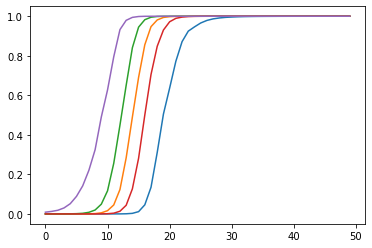

In [207]:
# Check for loop results
# species 1 is silvertip
plt.plot(AGE, mat5[1])
plt.plot(AGE, matmu[1])
plt.plot(AGE, mat75[1])
plt.plot(AGE, mat25[1])
plt.plot(AGE, mat95[1])

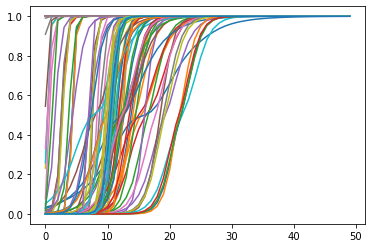

In [208]:
# Plot all new ogives

for i in range(nrows):
    plt.plot(AGE, matmu[i])
    

### Save results as dataframe

In [211]:
tsdata.columns

Index(['species_full', 'species_common', 'Stock', 'Region', 'Depth', 'Litter',
       'Offspring_size', 'Amax', 'Lmax', 'K', 'Interbirth_interval', 'Trophic',
       'Temperature'],
      dtype='object')

In [212]:
result2 = pd.DataFrame()

for i in range(nrows):
    tmp = tsdata.iloc[i]
    out = pd.DataFrame()
    out['matmu']=pd.Series(matmu[i])
    out['mat5']=pd.Series(mat5[i])
    out['mat25']=pd.Series(mat25[i])
    out['mat75']=pd.Series(mat75[i])
    out['mat95']=pd.Series(mat95[i])
    out['species_full']=tmp.species_full
    out['Stock']=tmp.Stock
    out['Region']=tmp.Region
    result2 = result2.append(out)
 
result2['age'] = result2.index

In [213]:
result2.head()

,matmu,mat5,mat25,mat75,mat95,species_full,Stock,Region,age
0,1.769769e-07,5.670870e-13,1.182714e-09,0.000016,0.007467,Carcharhinus albimarginatus,STIP-57,Eastern Indian,0
1,5.875279e-07,3.052312e-12,4.898829e-09,0.000039,0.010855,Carcharhinus albimarginatus,STIP-57,Eastern Indian,1
2,1.869016e-06,1.835197e-11,1.990031e-08,0.000097,0.016128,Carcharhinus albimarginatus,STIP-57,Eastern Indian,2
3,6.205441e-06,1.010971e-10,8.165784e-08,0.000235,0.028939,Carcharhinus albimarginatus,STIP-57,Eastern Indian,3
4,1.939708e-05,5.696340e-10,3.303636e-07,0.000584,0.047375,Carcharhinus albimarginatus,STIP-57,Eastern Indian,4


In [214]:
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
result2.to_csv('mat34_predicted_ogives_stocks.csv')


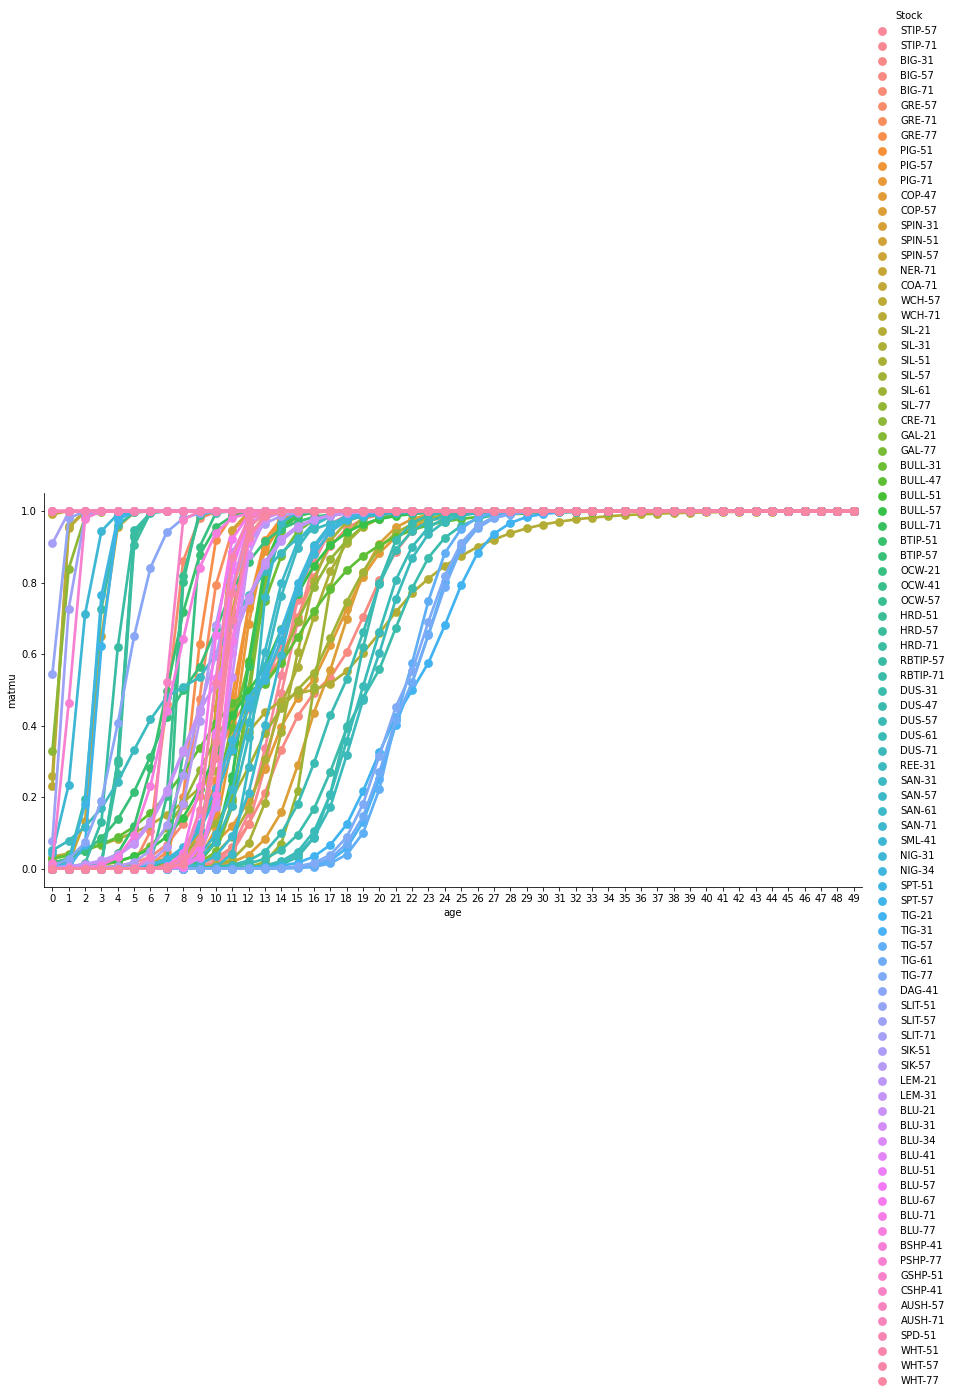

In [216]:
sns.catplot(x='age', y='matmu', hue='Stock', height=6, aspect=2, kind='point', data=result2);


## Do stock level summary stats  
 make a table of a50 per species

In [219]:
a50result2 = pd.DataFrame()

for i in range(nrows):
    tmp = tsdata.iloc[i]
    out = pd.DataFrame()
    out['a50mu']=pd.Series(a50mu[i])
    out['species_full']=tmp.species_full
    out['Stock']=tmp.Stock
    out['Region']=tmp.Region
    a50result2 = a50result2.append(out)
 

In [220]:
#check results
a50result2.head()

,a50mu,species_full,Stock,Region
0,13.750167,Carcharhinus albimarginatus,STIP-57,Eastern Indian
0,14.014564,Carcharhinus albimarginatus,STIP-71,Southwest Pacific
0,12.407059,Carcharhinus altimus,BIG-31,Western Atlantic
0,16.288772,Carcharhinus altimus,BIG-57,Eastern Indian
0,12.225898,Carcharhinus altimus,BIG-71,Southwest Pacific


In [221]:
#export table
a50result2.to_csv('mat34_predicteda50s_stocks.csv')

In [224]:
# make a table of S per species
Sresult2 = pd.DataFrame()

for i in range(nrows):
    tmp = tsdata.iloc[i]
    out = pd.DataFrame()
    out['smu']=pd.Series(smu[i])
    out['species_full']=tmp.species_full
    out['Stock']=tmp.Stock
    out['Region']=tmp.Region
    Sresult2 = Sresult2.append(out)

Sresult2.head()

,smu,species_full,Stock,Region
0,1.161462,Carcharhinus albimarginatus,STIP-57,Eastern Indian
0,1.146447,Carcharhinus albimarginatus,STIP-71,Southwest Pacific
0,0.892066,Carcharhinus altimus,BIG-31,Western Atlantic
0,0.706646,Carcharhinus altimus,BIG-57,Eastern Indian
0,0.706646,Carcharhinus altimus,BIG-71,Southwest Pacific


In [225]:
#export table
Sresult2.to_csv('mat34_predictedSs_stocks.csv')